### Author
0001128790 - Christian Di Buò - christian.dibuo@studio.unibo.it

### Importing images

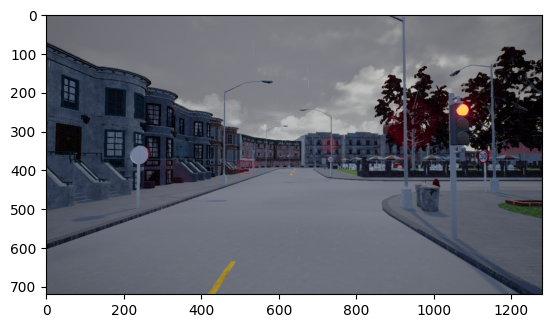

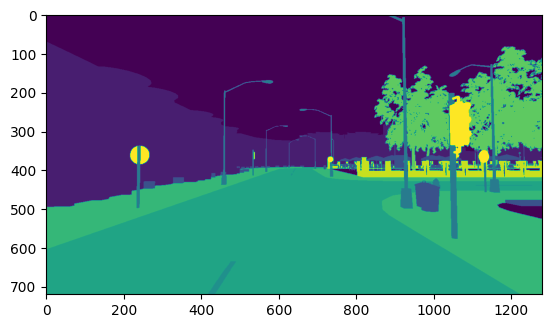

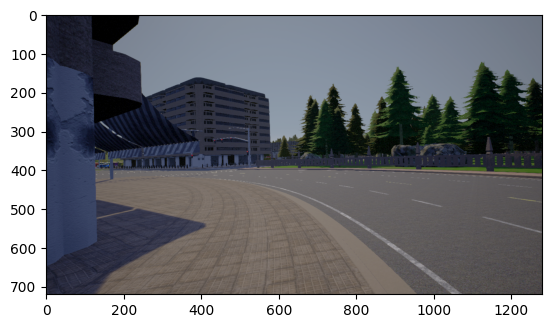

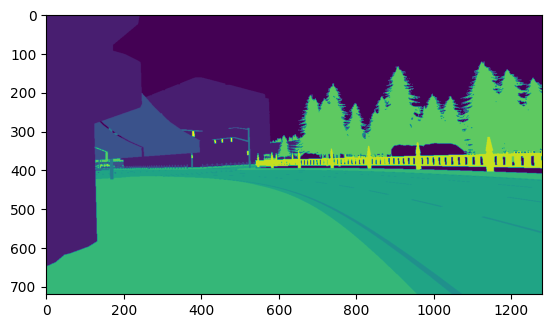

In [19]:
import os
from PIL import Image
import matplotlib.pyplot as plt

path = "/kaggle/input/streethazards_train/train"
train_images_path = f"{path}/images/training/t1-3"
train_labels_path = f"{path}/annotations/training/t1-3"
validation_images_path = f"{path}/images/validation/t4"
validation_labels_path = f"{path}/annotations/validation/t4"

def open_images(path):
    images = [Image.open(f'{path}/{images}') for images in os.listdir(path)]
    return images

train_img = open_images(train_images_path)
train_labels = open_images(train_labels_path)
validation_img = open_images(validation_images_path)
validation_labels = open_images(validation_labels_path)
plt.imshow(train_img[0]);
plt.show()
plt.imshow(train_labels[0]);
plt.show()
plt.imshow(validaiton_img[0]);
plt.show()
plt.imshow(validation_labels[0]);
plt.show()

All the train and validation images have the same shape

In [30]:
tr_shapes = {}
ann_shapes = {}

for tr_img in train_img:
    if tr_img.size not in tr_shapes:
        tr_shapes[tr_img.size] = 1
    else:
        tr_shapes[tr_img.size] += 1
        
for ann_img in validation_img:
    if ann_img.size not in ann_shapes:
        ann_shapes[ann_img.size] = 1
    else:
        ann_shapes[ann_img.size] += 1

print(tr_shapes, ann_shapes)

{(1280, 720): 5125} {(1280, 720): 1031}


copied from tutor repository

In [ ]:
"""
Source: https://github.com/hendrycks/anomaly-seg/issues/15#issuecomment-890300278
"""
import numpy as np
from PIL import Image


COLORS = np.array([
    [  0,   0,   0],  # unlabeled    =   0,
    [ 70,  70,  70],  # building     =   1,
    [190, 153, 153],  # fence        =   2, 
    [250, 170, 160],  # other        =   3,
    [220,  20,  60],  # pedestrian   =   4, 
    [153, 153, 153],  # pole         =   5,
    [157, 234,  50],  # road line    =   6, 
    [128,  64, 128],  # road         =   7,
    [244,  35, 232],  # sidewalk     =   8,
    [107, 142,  35],  # vegetation   =   9, 
    [  0,   0, 142],  # car          =  10,
    [102, 102, 156],  # wall         =  11, 
    [220, 220,   0],  # traffic sign =  12,
    [ 60, 250, 240],  # anomaly      =  13,
]) 


def color(annot_path: str, colors: np.ndarray) -> Image.Image:
    img_pil = Image.open(annot_path)
    img_np = np.array(img_pil)
    img_new = np.zeros((720, 1280, 3))

    for index, color in enumerate(colors):
        img_new[img_np == index + 1] = color
    
    return Image.fromarray(img_new.astype("uint8"), "RGB")


if __name__ == "__main__":
    annot_path = "/path/to/input/annotation"
    segm_map = color(annot_path, COLORS)
    segm_map.save("/path/to/output/map")